<a href="https://colab.research.google.com/github/Nysakun/Flight-Delay-Prediction/blob/main/flight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn (sklearn) for ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set styles
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

print("Libraries imported!")

Libraries imported!


In [2]:
# Cell 2: Load the Datasets
# NOTE: The 'flights.csv' file is HUGE (5.8 million rows).
# We will use 'nrows' to load a smaller, random sample for faster training.
# For your final project, you can try running it on the full dataset (it will take time).

NROWS_TO_LOAD = 500000  # Load the first 500k rows

try:
    df_flights = pd.read_csv('flights.csv', nrows=NROWS_TO_LOAD)
    df_airlines = pd.read_csv('airlines.csv')
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print("Error: Make sure 'flights.csv' and 'airlines.csv' are uploaded to Colab.")

# Display info
if 'df_flights' in locals():
    print("\n--- Flight Data Info ---")
    df_flights.info()
    print("\n--- Airlines Data Info ---")
    df_airlines.info()

Datasets loaded successfully!

--- Flight Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 500000 non-null  int64  
 1   MONTH                500000 non-null  int64  
 2   DAY                  500000 non-null  int64  
 3   DAY_OF_WEEK          500000 non-null  int64  
 4   AIRLINE              500000 non-null  object 
 5   FLIGHT_NUMBER        500000 non-null  int64  
 6   TAIL_NUMBER          496250 non-null  object 
 7   ORIGIN_AIRPORT       500000 non-null  object 
 8   DESTINATION_AIRPORT  500000 non-null  object 
 9   SCHEDULED_DEPARTURE  500000 non-null  int64  
 10  DEPARTURE_TIME       483584 non-null  float64
 11  DEPARTURE_DELAY      483584 non-null  float64
 12  TAXI_OUT             483296 non-null  float64
 13  WHEELS_OFF           483296 non-null  float64
 14  SCHEDULED_TI

In [3]:
# Cell 3: Merge Data and Check Missing Values
if 'df_flights' in locals() and 'df_airlines' in locals():
    # Merge airline names into the flight data
    # 'df_airlines' has IATA_CODE (e.g., 'AA') and AIRLINE (e.g., 'American Airlines')
    df = df_flights.merge(df_airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')

    # Check for missing values
    print("\n--- Missing Values (Original) ---")
    # See how many rows are missing the delay time
    print(df['DEPARTURE_DELAY'].isnull().sum())

    # We can't use rows where we don't know the delay
    df.dropna(subset=['DEPARTURE_DELAY'], inplace=True)

    print(f"\nMissing delay values dropped. New shape: {df.shape}")


--- Missing Values (Original) ---
16416

Missing delay values dropped. New shape: (483584, 33)


In [4]:
# Cell 4: Define the Target Variable (y)
# This is the most important step for a classification problem.
# GOAL: Predict if a flight is delayed (1) or not (0).
# We define "delayed" as 15 minutes or more.

if 'df' in locals():
    df['IS_DELAYED'] = (df['DEPARTURE_DELAY'] > 15).astype(int)

    # Display the counts
    print("\n--- Target Variable 'IS_DELAYED' ---")
    print(df['IS_DELAYED'].value_counts())


--- Target Variable 'IS_DELAYED' ---
IS_DELAYED
0    389878
1     93706
Name: count, dtype: int64


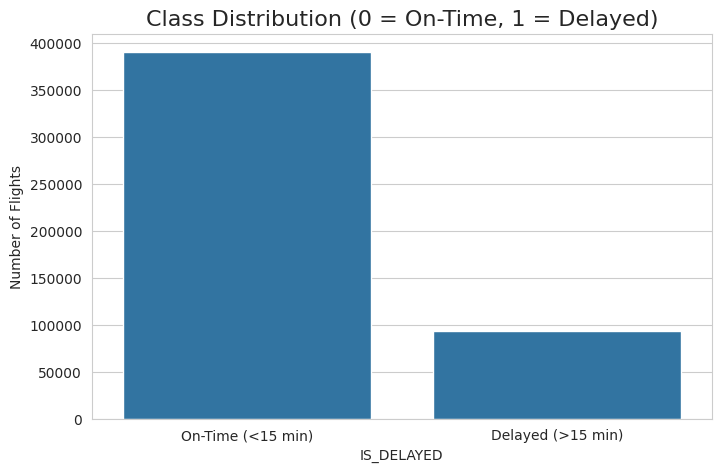

In [5]:
# Cell 5: EDA - Target Imbalance
if 'df' in locals():
    plt.figure(figsize=(8, 5))
    sns.countplot(x='IS_DELAYED', data=df)
    plt.title('Class Distribution (0 = On-Time, 1 = Delayed)', fontsize=16)
    plt.xticks([0, 1], ['On-Time (<15 min)', 'Delayed (>15 min)'])
    plt.ylabel('Number of Flights')
    plt.show()

/tmp/ipython-input-3991406327.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IS_DELAYED', y='AIRLINE_y', data=airline_delays, palette='viridis')


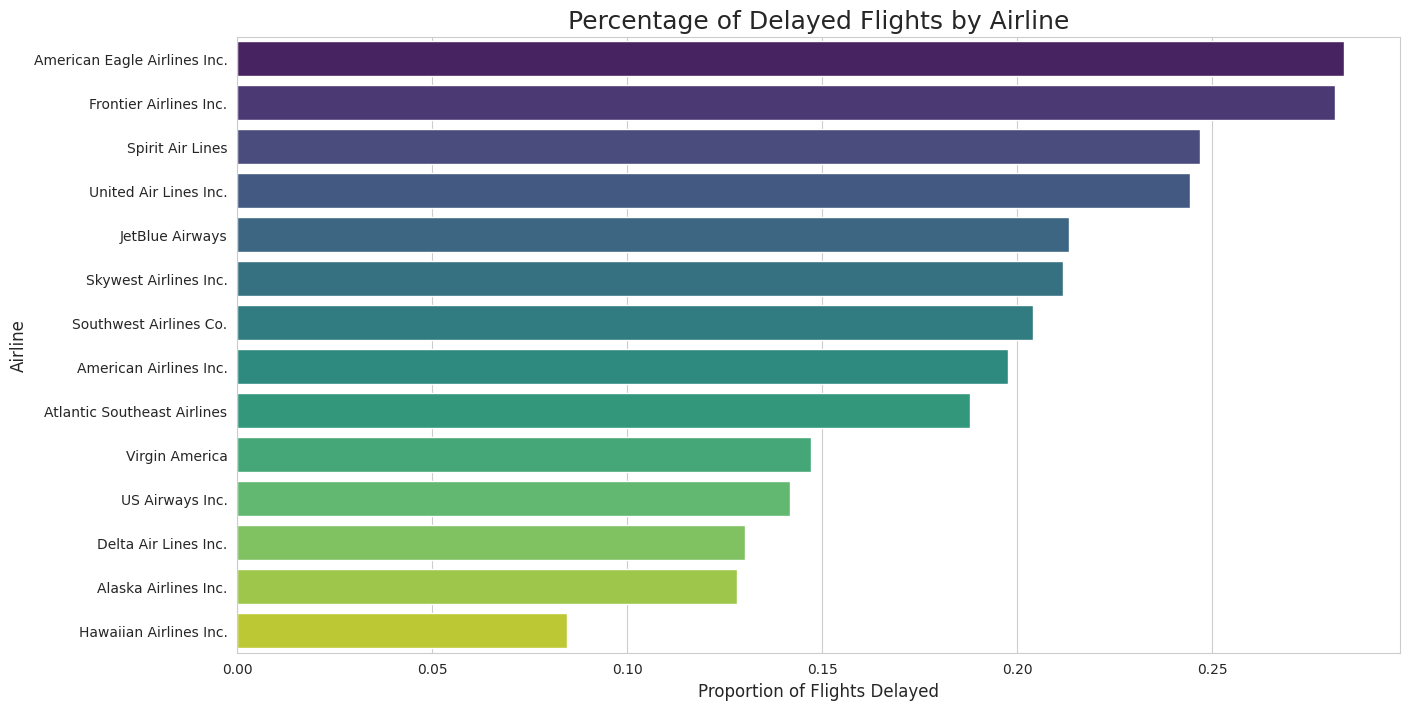

In [6]:
# Cell 6: EDA - Delays by Airline
if 'df' in locals():
    # Calculate the percentage of delayed flights for each airline
    airline_delays = df.groupby('AIRLINE_y')['IS_DELAYED'].mean().sort_values(ascending=False).reset_index()

    plt.figure(figsize=(15, 8))
    sns.barplot(x='IS_DELAYED', y='AIRLINE_y', data=airline_delays, palette='viridis')
    plt.title('Percentage of Delayed Flights by Airline', fontsize=18)
    plt.xlabel('Proportion of Flights Delayed', fontsize=12)
    plt.ylabel('Airline', fontsize=12)
    plt.show()

In [9]:
# Cell 7: Select and Engineer Features
if 'df' in locals():
    # 1. Select the raw features we'll use
    # These match the factors in your image
    features = [
        'MONTH',
        'DAY_OF_WEEK',
        'AIRLINE_x',             # e.g., 'AA'
        'ORIGIN_AIRPORT',      # e.g., 'JFK'
        'DESTINATION_AIRPORT', # e.g., 'LAX'
        'SCHEDULED_DEPARTURE', # e.g., 1305 (for 1:05 PM)
        'DISTANCE'
    ]
    target = 'IS_DELAYED'

    # 2. Create a new dataframe for our model
    model_df = df[features + [target]].copy()

    # 3. FEATURE ENGINEERING

    # Problem: 'SCHEDULED_DEPARTURE' (e.g., 930) isn't a useful number.
    # Solution: Extract the hour. 9:30 AM (930) and 9:45 AM (945) are
    # similar, but the model sees 945 as "bigger". The *hour* is more important.
    model_df['DEPARTURE_HOUR'] = (model_df['SCHEDULED_DEPARTURE'] // 100)

    # Problem: 'AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT' are strings.
    # Solution: Use LabelEncoder to turn them into numbers.
    categorical_features = ['AIRLINE_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

    for col in categorical_features:
        le = LabelEncoder()
        model_df[col] = le.fit_transform(model_df[col])

    # 4. Drop the old, unused column
    model_df.drop(columns=['SCHEDULED_DEPARTURE'], inplace=True)

    print("\n--- Final Data for Model ---")
    print(model_df.head())


--- Final Data for Model ---
   MONTH  DAY_OF_WEEK  AIRLINE_x  ORIGIN_AIRPORT  DESTINATION_AIRPORT  \
0      1            4          1              15                  269   
1      1            4          0             169                  227   
2      1            4         11             270                   63   
3      1            4          0             169                  196   
4      1            4          1             269                   15   

   DISTANCE  IS_DELAYED  DEPARTURE_HOUR  
0      1448           0               0  
1      2330           0               0  
2      2296           0               0  
3      2342           0               0  
4      1448           0               0  


In [10]:
# Cell 8: Split Data into Train and Test sets
if 'model_df' in locals():
    X = model_df.drop(columns=[target])
    y = model_df[target]

    # Split the data (30% for testing)
    # 'stratify=y' ensures the train and test sets have the same
    # proportion of delayed/on-time flights as the original data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")

X_train shape: (338508, 7)
X_test shape: (145076, 7)


In [11]:
# Cell 9: Train the Random Forest Model
if 'X_train' in locals():
    # n_estimators=100 is a good default (100 "trees" in the forest)
    # class_weight='balanced' is our solution to the imbalanced data!
    # n_jobs=-1 uses all available CPU cores to speed up training

    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    )

    print("Training model... This will take a minute or two.")
    model.fit(X_train, y_train)
    print("Model training complete!")

Training model... This will take a minute or two.
Model training complete!


In [12]:
# Cell 10: Classification Report
if 'model' in locals():
    y_pred = model.predict(X_test)

    print("\n--- Classification Report ---")
    # This report is the most important output
    print(classification_report(y_test, y_pred, target_names=['On-Time (0)', 'Delayed (1)']))


--- Classification Report ---
              precision    recall  f1-score   support

 On-Time (0)       0.83      0.79      0.81    116964
 Delayed (1)       0.26      0.31      0.29     28112

    accuracy                           0.69    145076
   macro avg       0.54      0.55      0.55    145076
weighted avg       0.72      0.69      0.70    145076



/tmp/ipython-input-3577637133.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Actual On-Time', 'Actual Delayed'])
/tmp/ipython-input-3577637133.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['Actual On-Time', 'Actual Delayed'])


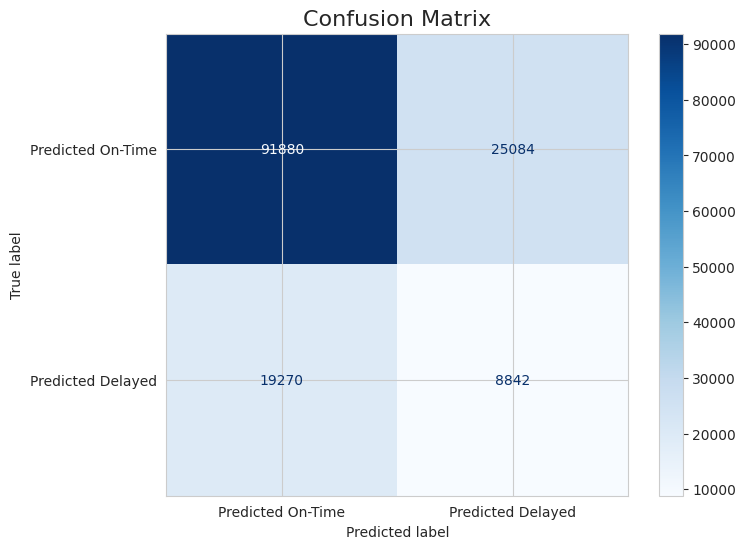

In [13]:
# Cell 11: Confusion Matrix
if 'model' in locals():
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Predicted On-Time', 'Predicted Delayed']
    )

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xticklabels(['Actual On-Time', 'Actual Delayed'])
    ax.set_yticklabels(['Actual On-Time', 'Actual Delayed'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=16)
    plt.show()

/tmp/ipython-input-3400958839.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances, palette='rocket')


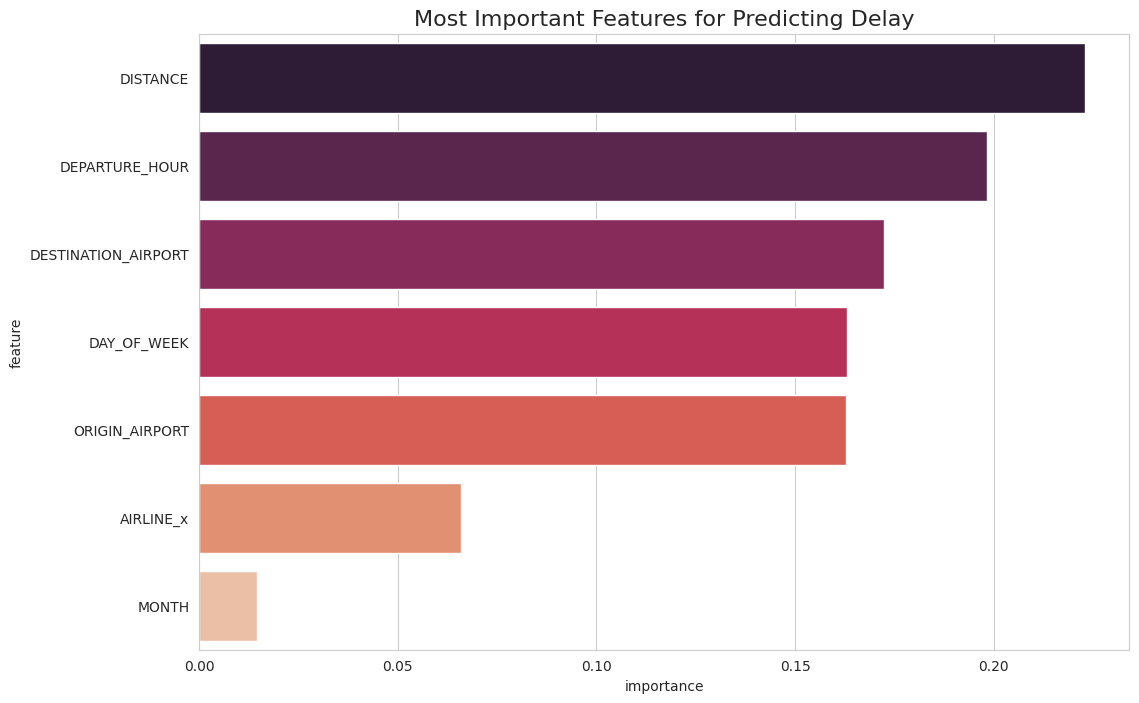

In [14]:
# Cell 12: Feature Importance
if 'model' in locals():
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importances, palette='rocket')
    plt.title('Most Important Features for Predicting Delay', fontsize=16)
    plt.show()